<a href="https://colab.research.google.com/github/MaxSMCON/Group3/blob/main/Group3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# import numpy as np, pandas as pd
# import matplotlib.pyplot as plt, seaborn as sns
# from tqdm import tqdm
# import warnings
# # warnings.filterwarnings("ignore")

# Spotify Database Exploration

### in order to uplod Spatify database from Kaggle you need to download kaggle.json key file. and uplod this into the folder: /content

In [3]:
import os

os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [4]:
!kaggle datasets download -d pepepython/spotify-huge-database-daily-charts-over-3-years

 91% 174M/191M [00:01<00:00, 84.6MB/s]
100% 191M/191M [00:01<00:00, 105MB/s] 


In [5]:
!unzip \*.zip && rm *.zip

Archive:  spotify-huge-database-daily-charts-over-3-years.zip
  inflating: Database to calculate popularity.csv  
  inflating: Final database.csv      


In [6]:
import pandas as pd
df = pd.read_csv('/content/Final database.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (7,8,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
df.head()

,Country,Uri,Popularity,Title,Artist,Album/Single,Genre,Artist_followers,Explicit,Album,...,Sweden,Switzerland,Taiwan,Turkey,UK,USA,Popu_max,Top10_dummy,Top50_dummy,Cluster
0,Global,https://open.spotify.com/track/6FyRXC8tJUh863J...,31833.95,adan y eva,Paulo Londra,single,argentine hip hop,11427104.0,False,Adan y Eva,...,0,0,0,0,0,0,10,1.0,1.0,global
1,USA,https://open.spotify.com/track/6FyRXC8tJUh863J...,8.00,adan y eva,Paulo Londra,single,argentine hip hop,11427104.0,False,Adan y Eva,...,0,0,0,0,0,1,191,0.0,0.0,english speaking and nordic
2,Argentina,https://open.spotify.com/track/6FyRXC8tJUh863J...,76924.40,adan y eva,Paulo Londra,single,argentine hip hop,11427104.0,False,Adan y Eva,...,0,0,0,0,0,0,1,1.0,1.0,spanish speaking
3,Belgium,https://open.spotify.com/track/6FyRXC8tJUh863J...,849.60,adan y eva,Paulo Londra,single,argentine hip hop,11427104.0,False,Adan y Eva,...,0,0,0,0,0,0,126,0.0,0.0,english speaking and nordic
4,Switzerland,https://open.spotify.com/track/6FyRXC8tJUh863J...,20739.10,adan y eva,Paulo Londra,single,argentine hip hop,11427104.0,False,Adan y Eva,...,0,1,0,0,0,0,21,0.0,1.0,english speaking and nordic


In [8]:
 ! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
 from google.colab import files

# files.upload()

In [10]:
%%capture
!pip install pyspark
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'svg'
sns.set_palette('rainbow')
sns.set_style('whitegrid')
import plotly.express as px
# these 2 lines fix a sporatic loading error in plotly
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
sns.set_style('darkgrid')
# pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col


from sklearn.pipeline import Pipeline
# from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

CSV_FILE= 'Final database.csv'
# CSV_FILE= '/kaggle/input/spotify-huge-database-daily-charts-over-3-years/Database to calculate popularity.csv'

In [11]:
CSV_FILE

'Final database.csv'

In [12]:
spark = SparkSession.builder.master("local[2]").appName("Spotify-Huge-Dataset").getOrCreate() #.enableHiveSupport()
spark

In [13]:
%%time
df = spark.read.option("header", True).csv(CSV_FILE)
df = df.withColumn("Release_date", F.to_date("Release_date", "yyyy-MM-dd"))
numerical_features = ['danceability', 'energy', 'instrumentalness', 'valence', 'liveliness', 'speechiness', 'acoustics',
                      'instrumentalness', 'tempo', 'duration_ms', 
                      'time_signature', 'Days_since_release', 'n_words']

for c in numerical_features:
    df = df.withColumn(c, df[c].cast("float"))
    
cols_to_drop = ['syuzhet_norm', 'bing_norm', 'afinn_norm', 'nrc_norm', 'syuzhet', 'bing'] 
for c in cols_to_drop:
    df.drop(c).collect()
    
df.printSchema()
# df.show(n=1, truncate=False, vertical=True)

root
 |-- Country0: string (nullable = true)
 |-- Uri: string (nullable = true)
 |-- Popularity: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Artist: string (nullable = true)
 |-- Album/Single: string (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Artist_followers: string (nullable = true)
 |-- Explicit: string (nullable = true)
 |-- Album9: string (nullable = true)
 |-- Release_date: date (nullable = true)
 |-- Track_number: string (nullable = true)
 |-- Tracks_in_album: string (nullable = true)
 |-- danceability: float (nullable = true)
 |-- energy: float (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- acoustics: float (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- liveliness: float (nullable = true)
 |-- valence: float (nullable = true)
 |-- tempo: float (nullable = true)
 |-- duration_ms: float (nul

In [14]:
df.select(["Title","Artist"]).distinct().count()


56241

In [2]:
type(df)

NameError: ignored

In [1]:
df.head(3)

NameError: ignored

In [16]:
record = df.select(["Title","Artist"]).distinct().count() / df.select(["Title","Artist"]).count()
print("portion of distinct songs:" ,round(record, 2))

portion of distinct songs: 0.33


In [17]:
print(df[numerical_features])

DataFrame[danceability: float, energy: float, instrumentalness: float, valence: float, liveliness: float, speechiness: float, acoustics: float, instrumentalness: float, tempo: float, duration_ms: float, time_signature: float, Days_since_release: float, n_words: float]


In [18]:
print("Dataset Shape using spark syntax:\n",(df.count(), len(df.columns)))


Dataset Shape using spark syntax:
 (170633, 151)


In [19]:
df.groupBy("Artist").count().orderBy("count", ascending=False).toPandas()

,Artist,count
0,Ariana Grande,1487
1,Drake,1473
2,BTS,1376
3,Taylor Swift,1285
4,XXXTENTACION,989
...,...,...
25519,Aloe Blacc - JID,1
25520,The Script - Christy Dignam,1
25521,Bunbury - Andrés Calamaro,1
25522,Ed Struijlaart,1


In [20]:
# each count is a song that was in the top 200 most played on a day on spotify during the last 3 years
result_df = (df.groupBy("Artist")
               .count()
               .orderBy("count", ascending=False)
               .limit(20)
               .toPandas()
            )
# px.bar(result_df, y='Artist', x='count', title='Most Prolific Artists')

In [ ]:
# same as above but with seaborn (sometimes plotly doesn't show up in the published notebok)
sns.barplot(data=result_df, y='Artist', x='count').set_title('Most Prolific Artists');

In [22]:
df.head()

Row(Country0='Global', Uri='https://open.spotify.com/track/6FyRXC8tJUh863JCkyWqtk', Popularity='31833.95', Title='adan y eva', Artist='Paulo Londra', Album/Single='single', Genre='argentine hip hop', Artist_followers='11427104.0', Explicit='False', Album9='Adan y Eva', Release_date=datetime.date(2018, 11, 5), Track_number='1', Tracks_in_album='1', danceability=0.7670000195503235, energy=0.7089999914169312, key='1', loudness='-4.47', mode='1', speechiness=0.335999995470047, acoustics=0.3230000138282776, instrumentalness=0.0, liveliness=0.06759999692440033, valence=0.7200000286102295, tempo=171.9929962158203, duration_ms=258639.0, time_signature=4.0, Genre_new='hip hop', Days_since_release=740.0, Released_after_2017='1.0', Explicit_false='1', Explicit_true='0', album31='0', compilation='0', single='1', bolero='0', boy band='0', country36='0', dance/electronic='0', else='0', funk='0', hip hop='1', house='0', indie='0', jazz='0', k-pop='0', latin='0', metal='0', opm='0', pop='0', r&b/soul=

In [23]:
df.createOrReplaceTempView("df_table")


In [24]:
print("Now using the SQL Context. We can check it's the same length as before")
query = """
    SELECT Count(*) as Dataset_Length
    FROM df_table
"""
res = spark.sql(query).show()

Now using the SQL Context. We can check it's the same length as before
+--------------+
|Dataset_Length|
+--------------+
|        170633|
+--------------+



In [25]:
# Most popular artist (by sum of popularity of songs) in the USA
query = """
SELECT
                                    Artist, 
       ROUND(SUM(Popularity), 2) AS Populartiy
FROM df_table
WHERE USA == 1
GROUP BY Artist
ORDER BY AVG(Popularity) DESC
LIMIT 10
"""

res = spark.sql(query)
res.show(10, truncate=False)

+------------------------------+----------+
|Artist                        |Populartiy|
+------------------------------+----------+
|Post Malone - Quavo           |130719.15 |
|XXXTENTACION - Trippie Redd   |97016.35  |
|Meek Mill - Drake             |83235.95  |
|Post Malone - 21 Savage       |159633.25 |
|Billie Eilish - Khalid        |79693.9   |
|Marshmello - Bastille         |74560.5   |
|Cardi B - Bad Bunny - J Balvin|74381.6   |
|Migos - Lil Uzi Vert          |70138.2   |
|BlocBoy JB - Drake            |69576.75  |
|Kendrick Lamar - Zacari       |67838.15  |
+------------------------------+----------+



In [ ]:
# select only the songs released in 1939
(df.filter(F.year(df['Release_date']) == 1939)
   .select('Title', 'Artist','Release_date', 'Genre')
   .distinct()
   .show(5, truncate=False)
)

In [ ]:
query = """
SELECT
        ROUND(Year(Release_date), -1) AS Decade,
        Round(Popularity, 2)          AS Popularity,
                                         Title,
                                         Artist
FROM df_table
INNER JOIN (SELECT Max(Popularity) as mp
            FROM df_table
            WHERE ROUND(Year(Release_date), -1) IS NOT NULL
            AND USA == 1
            GROUP BY ROUND(Year(Release_date), -1)
           ) AS temp
ON temp.mp = df_table.Popularity
ORDER BY Decade ASC, Popularity ASC
"""

res = spark.sql(query)
res.toPandas().drop_duplicates(subset='Decade', keep="last")

In [28]:
# highly optimized version of the above query via scalar-aggregate-reduction
query = """
SELECT
    ROUND(Year(Release_date), -1) as Decade,
    ROUND(Max(Popularity), 2) as Popularity,
    SUBSTRING(MAX(CONCAT(LPAD(Popularity, 11, 0), Title)), 12) AS Title,
    SUBSTRING(MAX(CONCAT(LPAD(Popularity, 11, 0), Artist)), 12) AS Artist
FROM
    df_table
WHERE
    ROUND(Year(Release_date), -1) IS NOT NULL
    AND USA == 1
GROUP BY Decade
ORDER BY Decade ASC
"""

spark.sql(query).show()

+------+----------+--------------------+--------------------+
|Decade|Popularity|               Title|              Artist|
+------+----------+--------------------+--------------------+
|  1940|     840.5|     white christmas|Bing Crosby - Ken...|
|  1950|     997.6|ill be home for c...|         Bing Crosby|
|  1960|   9704.95|    jingle bell rock|         Bobby Helms|
|  1970|      98.4|what christmas me...|       Stevie Wonder|
|  1980|      98.6|dreams - 2004 rem...|       Fleetwood Mac|
|  1990|     97.75|            spoonman|         Soundgarden|
|  2000|   9476.05|       feliz navidad|      José Feliciano|
|  2010|     97.75|         tongue tied|           Grouplove|
|  2020|   99912.3|       drip too hard|    Lil Baby - Gunna|
+------+----------+--------------------+--------------------+



In [ ]:
 # Most popular genres, period.
query = """
SELECT Genre, COUNT(*) AS Tally
FROM df_table
GROUP BY Genre
ORDER BY Tally DESC
"""
spark.sql(query).show(5)

In [ ]:
query = """
SELECT
      ROUND(Year(Release_date), -1) AS Decade,
      Genre, COUNT(Genre)           AS counts
FROM  df_table
WHERE ROUND(Year(Release_date), -1) IS NOT NULL
GROUP BY Decade, Genre
ORDER BY COUNT(Genre) DESC
"""

res = (spark.sql(query)
            .dropDuplicates(subset=['Decade'])
            .orderBy('Decade')
            .show()
      )
# res.toPandas().drop_duplicates(subset='Decade', keep="first")


In [ ]:
query = """
SELECT Title, Artist, Release_date, MAX(Popularity)
FROM df_table
WHERE Artist == "Paulo Londra"
GROUP BY Title, Artist, Release_date
LIMIT 10
"""

res = spark.sql(query).show()

In [ ]:
sound_features = ['danceability', 'energy', 'instrumentalness', 'valence', 'liveliness', 'speechiness', 'acoustics']
col_names = ['Decade']
col_names.extend(sound_features)

df_music_features = (df.sample(.2, seed=42)
                       .groupBy(F.round(F.year(df.Release_date), -1))
                       .agg({feature: 'mean' for feature in sound_features})
                       .toDF(*col_names)
                       .orderBy('Decade')
                       .toPandas()
                       .dropna(axis=0)
                    )
# fig = px.line(df_music_features, x='Decade', y=sound_features, title='Song Characteristics Over the Decades')
# fig.show()


Text(0.5, 1.0, 'Song Characteristics Over the Decades')

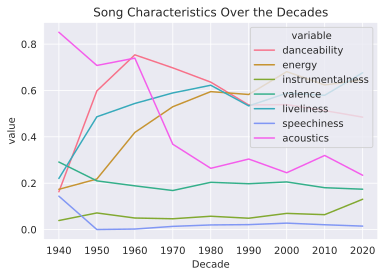

In [33]:
# same as above but with seaborn. (sometimes plotly doesn't show up in the published notebok)
sns.lineplot(data=pd.melt(df_music_features, 
                          ['Decade']),
                           x='Decade', 
                          y='value', 
                          hue='variable').set_title('Song Characteristics Over the Decades')

# New Section

In [1]:
df

NameError: ignored

In [ ]:
# ! install kaggle_secrets

In [ ]:
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# SPOTIFY_CLIENT_ID = user_secrets.get_secret("SPOTIFY_CLIENT_ID")
# SPOTIFY_CLIENT_SECRET = user_secrets.get_secret("SPOTIFY_CLIENT_SECRET")

ModuleNotFoundError: ignored